In [2]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2B3

In [3]:
# Cell 2: Define constants
BATCH_SIZE = 64
IMG_HEIGHT = 300 
IMG_WIDTH = 300
DATA_DIR = "/home/anon/MajorProject/Data/final_asl_mix"

In [4]:
# Cell 3: Load data

#train and test if already separated
# TRAIN_DATA_DIR = "/home/anon/MajorProject/Data/ASL_MAIN/asl_alphabet_train"
# TEST_DATA_DIR = "/home/anon/MajorProject/Data/Synthetic_Dataset/test"

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)


train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 84470 files belonging to 19 classes.
Using 67576 files for training.


2024-02-21 16:20:12.086498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 16:20:12.376408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 16:20:12.376444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 16:20:12.378998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 16:20:12.379027: I external/local_xla/xla/stream_executor

Found 84470 files belonging to 19 classes.
Using 16894 files for validation.
['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'K', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space']


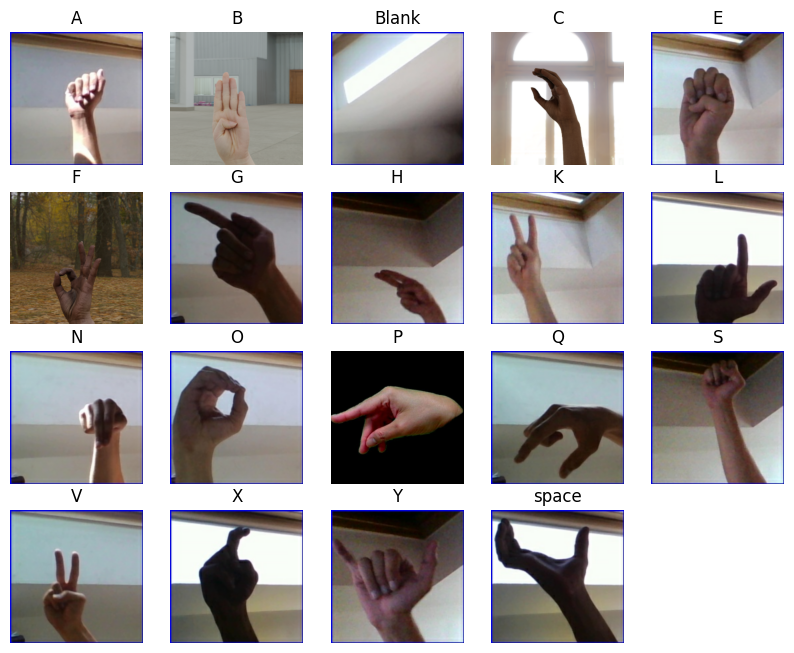

In [5]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Iterate over the images and labels in the current batch
  for image, label in zip(images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")



In [6]:
# Before data augmentation
for images, labels in train_ds.take(1):
  for image in images:
    print(image.shape)


(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


In [7]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        # layers.RandomWidth(0.1),
        layers.RandomCrop(IMG_HEIGHT, IMG_HEIGHT),
    ]
)

In [8]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [9]:
# After data augmentation
for images, labels in train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y)).take(1):
    for image in images:
        print(image.shape)

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


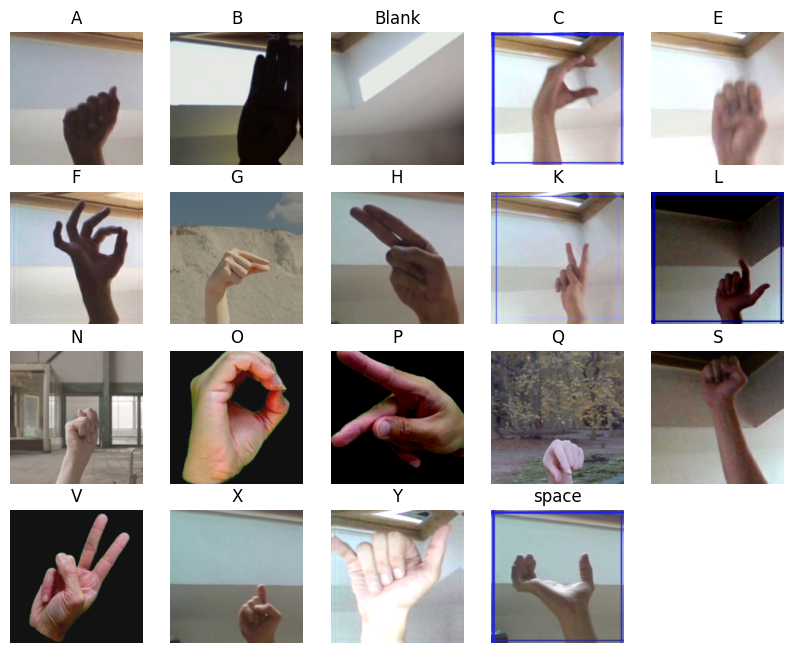

In [10]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Apply data augmentation
  augmented_images = tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), images)
  
  # Iterate over the images and labels in the current batch
  for image, label in zip(augmented_images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")


In [11]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetV2B3(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

In [12]:
for images, labels in train_ds.take(1):
    print(f'Training images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in val_ds.take(1):
    print(f'Validation images shape: {images.shape}, labels shape: {labels.shape}')


Training images shape: (64, 300, 300, 3), labels shape: (64,)
Validation images shape: (64, 300, 300, 3), labels shape: (64,)


In [13]:
print(model.summary())

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 300, 300, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 300, 300, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 150, 150, 40)         1080      ['normalization[0][

In [14]:
# Cell 7: Define callbacks
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/home/anon/MajorProject/Non_Git/Checkpoints/final/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [15]:
#Cell 8 train the model
epochs = 30
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint,reduce_lr])

Epoch 1/30


2024-02-21 16:25:35.007915: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


   1/1056 [..............................] - ETA: 2:47:49 - loss: 4.8529 - accuracy: 0.0312 - sparse_categorical_accuracy: 0.0312 - sparse_top_k_categorical_accuracy: 0.2188

2024-02-21 16:25:37.610311: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcbc87623c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 16:25:37.610336: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-02-21 16:25:37.619434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708512037.668438    2002 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1056/1056 [==============================] - ETA: 0s - loss: 2.7274 - accuracy: 0.3492 - sparse_categorical_accuracy: 0.3492 - sparse_top_k_categorical_accuracy: 0.6944

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1056/1056 [==============================] - 165s 147ms/step - loss: 2.7274 - accuracy: 0.3492 - sparse_categorical_accuracy: 0.3492 - sparse_top_k_categorical_accuracy: 0.6944 - val_loss: 1.1747 - val_accuracy: 0.7863 - val_sparse_categorical_accuracy: 0.7863 - val_sparse_top_k_categorical_accuracy: 0.9577 - lr: 9.8895e-05
Epoch 2/30
1056/1056 [==============================] - 153s 145ms/step - loss: 1.5822 - accuracy: 0.6130 - sparse_categorical_accuracy: 0.6130 - sparse_top_k_categorical_accuracy: 0.9065 - val_loss: 0.8475 - val_accuracy: 0.8604 - val_sparse_categorical_accuracy: 0.8604 - val_sparse_top_k_categorical_accuracy: 0.9784 - lr: 9.7800e-05
Epoch 3/30
1056/1056 [==============================] - 152s 144ms/step - loss: 1.2437 - accuracy: 0.6999 - sparse_categorical_accuracy: 0.6999 - sparse_top_k_categorical_accuracy: 0.9434 - val_loss: 0.7027 - val_accuracy: 0.8916 - val_sparse_categorical_accuracy: 0.8916 - val_sparse_top_k_categorical_accuracy: 0.9864 - lr: 9.6718e-05


In [16]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2B3_300x300_final_asl_mix_FEB_21_batch_size_64_has_19_classes.h5')

In [17]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 [==============================] - 2s 753ms/step


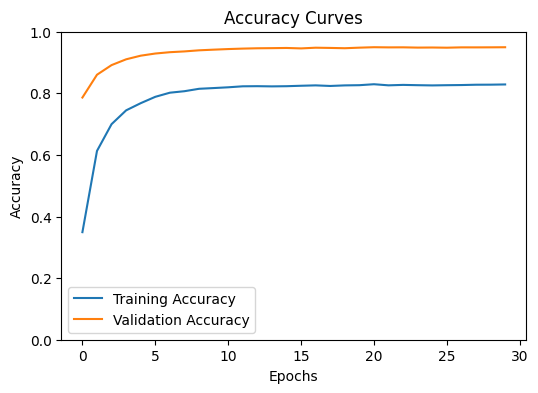

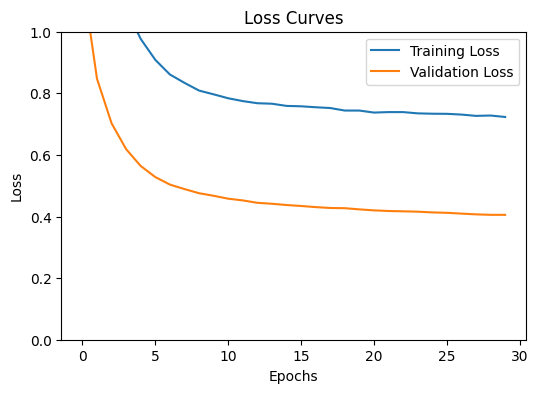

In [18]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


Class: A
Precision: 0.9505263157894737
Recall: 0.9435736677115988
F1 Score: 0.9470372312532774
AUC-ROC: 0.9703122777912954

Class: B
Precision: 0.9719222462203023
Recall: 0.9846827133479212
F1 Score: 0.9782608695652174
AUC-ROC: 0.9915278397778405

Class: Blank
Precision: 0.991504854368932
Recall: 0.9975579975579976
F1 Score: 0.9945222154595252
AUC-ROC: 0.9985612693855307

Class: C
Precision: 0.978675645342312
Recall: 0.9646017699115044
F1 Score: 0.9715877437325905
AUC-ROC: 0.9817067636299235

Class: E
Precision: 0.964873765093304
Recall: 0.9262381454162276
F1 Score: 0.9451612903225807
AUC-ROC: 0.9621156233509486

Class: F
Precision: 0.9745664739884393
Recall: 0.9304635761589404
F1 Score: 0.9520045172219085
AUC-ROC: 0.9645437720674611

Class: G
Precision: 0.9591121495327103
Recall: 0.9193729003359462
F1 Score: 0.938822184105203
AUC-ROC: 0.958592768523076

Class: H
Precision: 0.9383783783783783
Recall: 0.9897377423033067
F1 Score: 0.9633740288568258
AUC-ROC: 0.9930895117210484

Class: K


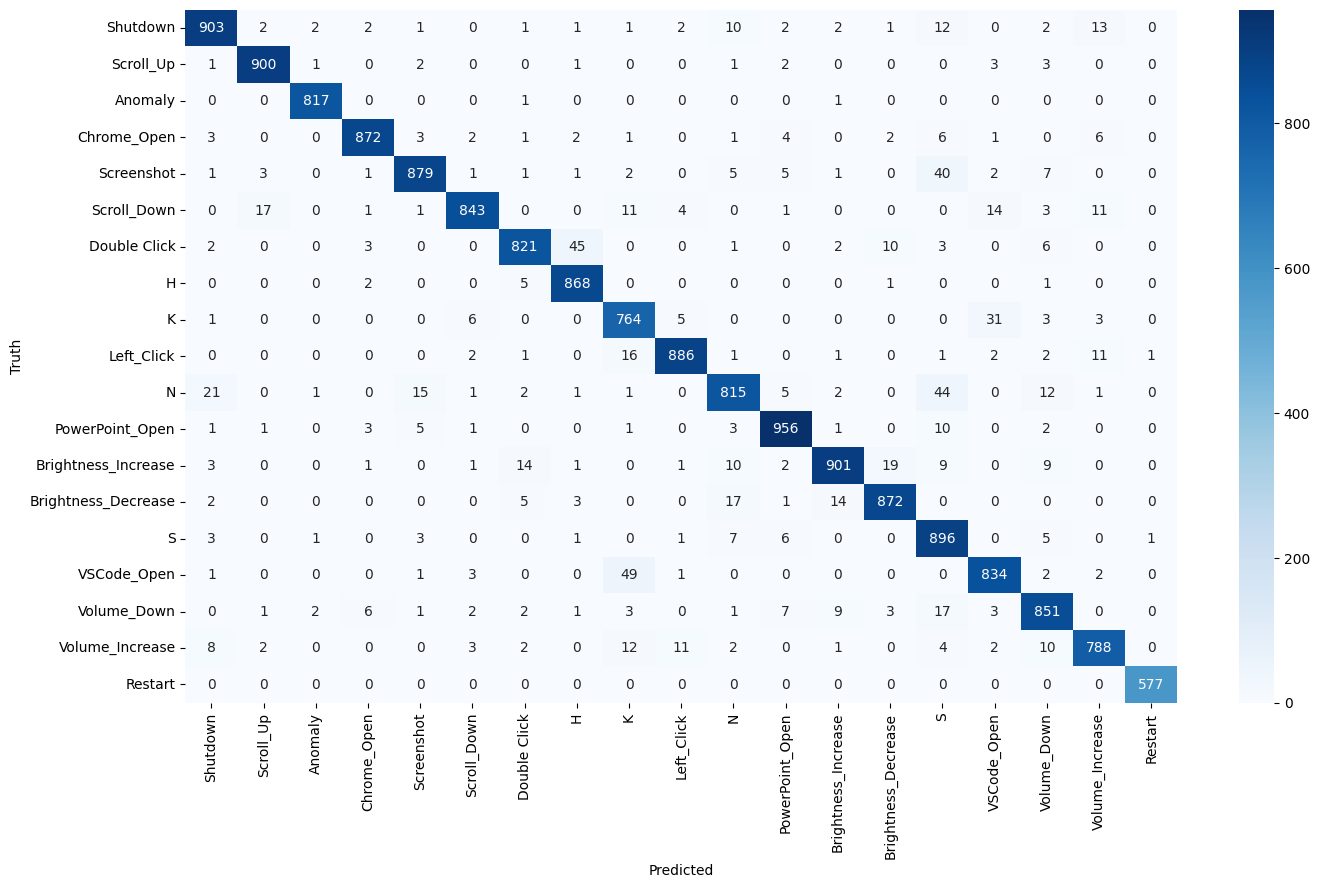

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# Define the mapping between class names and labels
# ['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'K', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space']

class_label_mapping = {
    'A': 'Shutdown',
    'B': 'Scroll_Up',
    'Blank': 'Anomaly',
    'C': 'Chrome_Open',
    'E': 'Screenshot',
    'F': 'Scroll_Down',
    'G': 'Double Click',
    'H': 'H',
    'I': 'I',
    'L': 'Left_Click',
    'N': 'N',
    'O': 'PowerPoint_Open',
    'P': 'Brightness_Increase',
    'Q': 'Brightness_Decrease',
    'R': 'Right_Click',
    'S': 'S',
    'V': 'VSCode_Open',
    'W': 'W',
    'X': 'Volume_Down',
    'Y': 'Volume_Increase',
    '5': 'Neutral',
    'space':'Restart',
    'K': 'K'
}
# Create a dictionary that maps indices to labels
class_labels = {i: class_label_mapping[name] for i, name in enumerate(class_names)}

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels.values(), yticklabels=class_labels.values(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [20]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block3a_expand_conv
34 block3a_expand_bn
35 block3a_expand_activation
36 block3a_project_conv
37 block3a_project_bn
38 block3b_expand_conv
39 block3b_expand_bn
40 block3b_expand_activation
41 block3b_project_conv
42 block3b_project_bn
43 block3b_drop
44 block3b_add
45 block3c_expand_conv
46 block3c_expand_bn
47 block3c_

In [21]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# # we chose to train the top 2 blocks, i.e. we will freeze
# # the first xxx layers and unfreeze the rest:
# for layer in model.layers[:514]:
#    layer.trainable = False
# for layer in model.layers[514:]:
#    layer.trainable = True
# # we need to recompile the model for these modifications to take effect
# # we train our model again (this time fine-tuning the top 2 blocks
# # alongside the top Dense layers
# optimizer = keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

# epochs = 5
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

for layer in model.layers[:410]:
   layer.trainable = False
for layer in model.layers[410:]:
   if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/10


2024-02-21 17:45:01.164364: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-21 17:45:01.214198: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - ETA: 0s - loss: 0.7193 - accuracy: 0.8302 - sparse_categorical_accuracy: 0.8302 - sparse_top_k_categorical_accuracy: 0.9806

2024-02-21 17:47:13.176619: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 160s 145ms/step - loss: 0.7193 - accuracy: 0.8302 - sparse_categorical_accuracy: 0.8302 - sparse_top_k_categorical_accuracy: 0.9806 - val_loss: 0.4043 - val_accuracy: 0.9503 - val_sparse_categorical_accuracy: 0.9503 - val_sparse_top_k_categorical_accuracy: 0.9964
Epoch 2/10
   1/1056 [..............................] - ETA: 3:58 - loss: 0.8293 - accuracy: 0.8125 - sparse_categorical_accuracy: 0.8125 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-21 17:47:34.551771: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 150s 142ms/step - loss: 0.7236 - accuracy: 0.8279 - sparse_categorical_accuracy: 0.8279 - sparse_top_k_categorical_accuracy: 0.9814 - val_loss: 0.4037 - val_accuracy: 0.9506 - val_sparse_categorical_accuracy: 0.9506 - val_sparse_top_k_categorical_accuracy: 0.9965
Epoch 3/10
   1/1056 [..............................] - ETA: 3:52 - loss: 0.6827 - accuracy: 0.8125 - sparse_categorical_accuracy: 0.8125 - sparse_top_k_categorical_accuracy: 1.0000

2024-02-21 17:50:04.336063: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - ETA: 0s - loss: 0.7206 - accuracy: 0.8286 - sparse_categorical_accuracy: 0.8286 - sparse_top_k_categorical_accuracy: 0.9805

2024-02-21 17:52:16.553452: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 154s 145ms/step - loss: 0.7206 - accuracy: 0.8286 - sparse_categorical_accuracy: 0.8286 - sparse_top_k_categorical_accuracy: 0.9805 - val_loss: 0.4028 - val_accuracy: 0.9509 - val_sparse_categorical_accuracy: 0.9509 - val_sparse_top_k_categorical_accuracy: 0.9966
Epoch 4/10
   1/1056 [..............................] - ETA: 3:57 - loss: 0.9475 - accuracy: 0.7500 - sparse_categorical_accuracy: 0.7500 - sparse_top_k_categorical_accuracy: 0.9375

2024-02-21 17:52:38.077969: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 153s 145ms/step - loss: 0.7215 - accuracy: 0.8278 - sparse_categorical_accuracy: 0.8278 - sparse_top_k_categorical_accuracy: 0.9817 - val_loss: 0.4025 - val_accuracy: 0.9510 - val_sparse_categorical_accuracy: 0.9510 - val_sparse_top_k_categorical_accuracy: 0.9966
Epoch 5/10
   1/1056 [..............................] - ETA: 3:58 - loss: 0.8715 - accuracy: 0.7969 - sparse_categorical_accuracy: 0.7969 - sparse_top_k_categorical_accuracy: 0.9688

2024-02-21 17:55:11.533572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 153s 145ms/step - loss: 0.7233 - accuracy: 0.8299 - sparse_categorical_accuracy: 0.8299 - sparse_top_k_categorical_accuracy: 0.9816 - val_loss: 0.4018 - val_accuracy: 0.9512 - val_sparse_categorical_accuracy: 0.9512 - val_sparse_top_k_categorical_accuracy: 0.9966
Epoch 6/10
   1/1056 [..............................] - ETA: 4:06 - loss: 0.8601 - accuracy: 0.7656 - sparse_categorical_accuracy: 0.7656 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-21 17:57:44.620924: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 152s 144ms/step - loss: 0.7209 - accuracy: 0.8284 - sparse_categorical_accuracy: 0.8284 - sparse_top_k_categorical_accuracy: 0.9823 - val_loss: 0.4016 - val_accuracy: 0.9516 - val_sparse_categorical_accuracy: 0.9516 - val_sparse_top_k_categorical_accuracy: 0.9966
Epoch 7/10
   1/1056 [..............................] - ETA: 3:50 - loss: 0.6462 - accuracy: 0.8750 - sparse_categorical_accuracy: 0.8750 - sparse_top_k_categorical_accuracy: 1.0000

2024-02-21 18:00:16.440394: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 152s 144ms/step - loss: 0.7188 - accuracy: 0.8303 - sparse_categorical_accuracy: 0.8303 - sparse_top_k_categorical_accuracy: 0.9817 - val_loss: 0.4024 - val_accuracy: 0.9515 - val_sparse_categorical_accuracy: 0.9515 - val_sparse_top_k_categorical_accuracy: 0.9967
Epoch 8/10
   1/1056 [..............................] - ETA: 3:59 - loss: 0.7143 - accuracy: 0.8281 - sparse_categorical_accuracy: 0.8281 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-21 18:02:48.432470: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 152s 144ms/step - loss: 0.7189 - accuracy: 0.8287 - sparse_categorical_accuracy: 0.8287 - sparse_top_k_categorical_accuracy: 0.9817 - val_loss: 0.4015 - val_accuracy: 0.9517 - val_sparse_categorical_accuracy: 0.9517 - val_sparse_top_k_categorical_accuracy: 0.9966
Epoch 9/10
   1/1056 [..............................] - ETA: 3:56 - loss: 0.8431 - accuracy: 0.7656 - sparse_categorical_accuracy: 0.7656 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-21 18:05:20.545961: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 152s 144ms/step - loss: 0.7223 - accuracy: 0.8282 - sparse_categorical_accuracy: 0.8282 - sparse_top_k_categorical_accuracy: 0.9813 - val_loss: 0.4019 - val_accuracy: 0.9516 - val_sparse_categorical_accuracy: 0.9516 - val_sparse_top_k_categorical_accuracy: 0.9967
Epoch 10/10
   1/1056 [..............................] - ETA: 3:59 - loss: 0.6411 - accuracy: 0.8125 - sparse_categorical_accuracy: 0.8125 - sparse_top_k_categorical_accuracy: 1.0000

2024-02-21 18:07:52.627154: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1056/1056 [==============================] - 152s 144ms/step - loss: 0.7194 - accuracy: 0.8299 - sparse_categorical_accuracy: 0.8299 - sparse_top_k_categorical_accuracy: 0.9806 - val_loss: 0.4008 - val_accuracy: 0.9516 - val_sparse_categorical_accuracy: 0.9516 - val_sparse_top_k_categorical_accuracy: 0.9967


In [22]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2024-02-21 18:11:10.621794: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 [==============================] - 1s 32ms/step


Class: A
Precision: 0.9594882729211087
Recall: 0.9404388714733543
F1 Score: 0.9498680738786279
AUC-ROC: 0.969027241471759

Class: B
Precision: 0.9793478260869565
Recall: 0.9857768052516411
F1 Score: 0.9825517993456925
AUC-ROC: 0.9922939095094251

Class: Blank
Precision: 0.9927095990279465
Recall: 0.9975579975579976
F1 Score: 0.9951278928136419
AUC-ROC: 0.9985923735845975

Class: C
Precision: 0.9754189944134078
Recall: 0.9657079646017699
F1 Score: 0.9705391884380211
AUC-ROC: 0.9821660523446623

Class: E
Precision: 0.962882096069869
Recall: 0.9293993677555321
F1 Score: 0.9458445040214477
AUC-ROC: 0.963633518935778

Class: F
Precision: 0.9716231555051078
Recall: 0.9448123620309051
F1 Score: 0.9580302182428652
AUC-ROC: 0.9716243446381695

Class: G
Precision: 0.952819332566168
Recall: 0.9272116461366181
F1 Score: 0.9398410896708286
AUC-ROC: 0.9623246531414296

Class: H
Precision: 0.9504405286343612
Recall: 0.984036488027366
F1 Score: 0.9669467787114846
AUC-ROC: 0.9906134865684685

Class: K


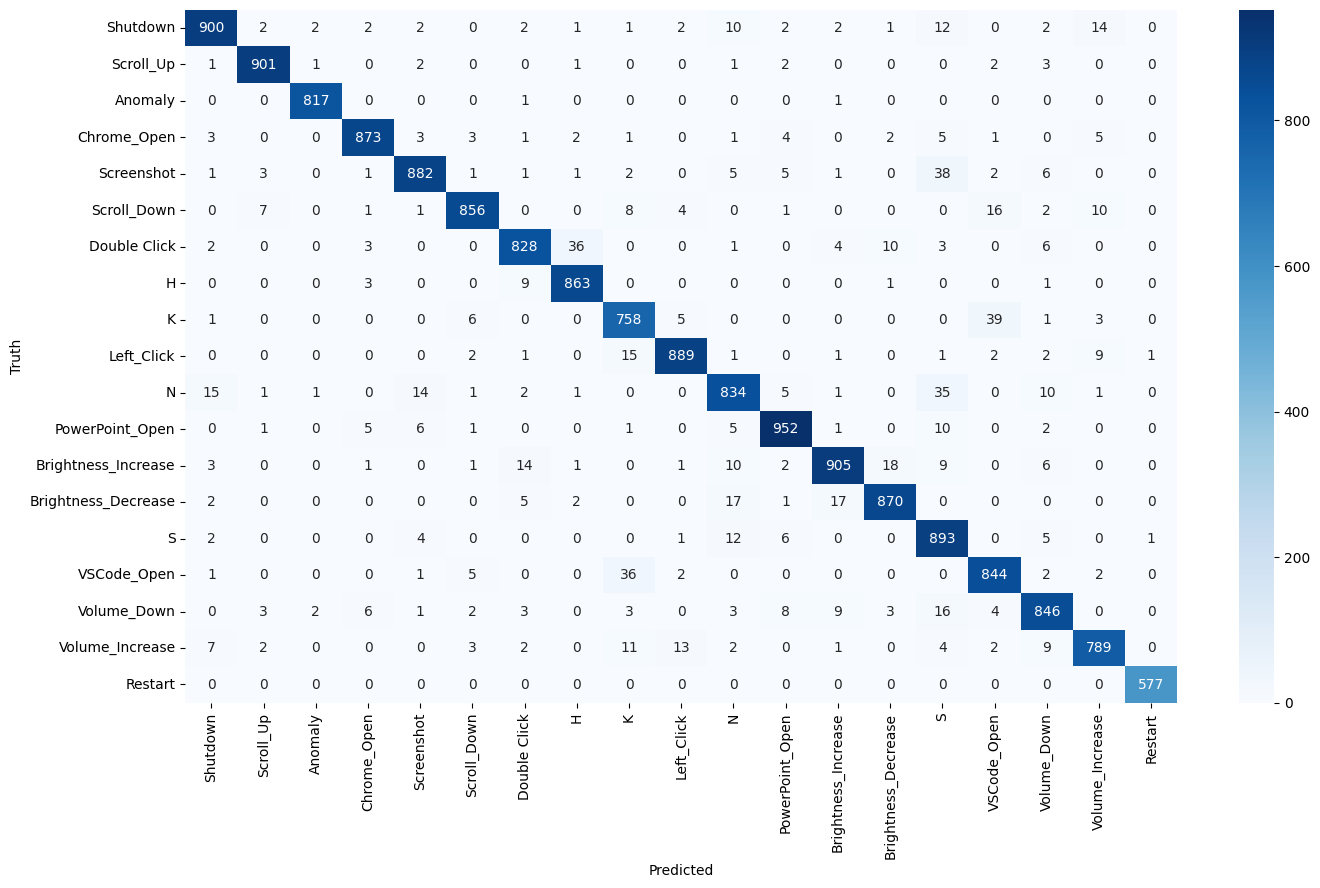

In [23]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import confusion_matrix, roc_auc_score
# from sklearn.preprocessing import LabelBinarizer
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Accuracy
# accuracy = accuracy_score(y_true, y_pred)

# # Precision, Recall, F1 Score
# average = 'macro'  # or 'micro', 'weighted', depending on the problem
# precision = precision_score(y_true, y_pred, average=average)
# recall = recall_score(y_true, y_pred, average=average)
# f1 = f1_score(y_true, y_pred, average=average)

# # AUC-ROC for multiclass
# lb = LabelBinarizer()
# lb.fit(y_true)
# y_true_lb = lb.transform(y_true)
# y_pred_lb = lb.transform(y_pred)
# auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)

# # Print metrics
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print(f"AUC-ROC: {auc_roc}")

# #for dataset_alpha
# # class_names = ['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Left_Click', 'Nothing', 'PowerPoint_Open', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'VSCode_Open', 'Volume_Decrease', 'Volume_Increase']


# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
# #for final_asl_mix
# # class_names = ['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']

# #feb 20 final
# class_names = ['5', 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'V', 'W', 'X', 'Y', 'space']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_label_mapping = {
    'A': 'Shutdown',
    'B': 'Scroll_Up',
    'Blank': 'Anomaly',
    'C': 'Chrome_Open',
    'E': 'Screenshot',
    'F': 'Scroll_Down',
    'G': 'Double Click',
    'H': 'H',
    'I': 'I',
    'L': 'Left_Click',
    'N': 'N',
    'O': 'PowerPoint_Open',
    'P': 'Brightness_Increase',
    'Q': 'Brightness_Decrease',
    'R': 'Right_Click',
    'S': 'S',
    'V': 'VSCode_Open',
    'W': 'W',
    'X': 'Volume_Down',
    'Y': 'Volume_Increase',
    '5': 'Neutral',
    'space':'Restart',
    'K': 'K'
}
# Create a dictionary that maps indices to labels
class_labels = {i: class_label_mapping[name] for i, name in enumerate(class_names)}
# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels.values(), yticklabels=class_labels.values(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9750320858885018


In [25]:
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2B3_300x300_final_asl_mix_FEB_21_batch_size_64_has_19_classes_finetuned.h5')

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


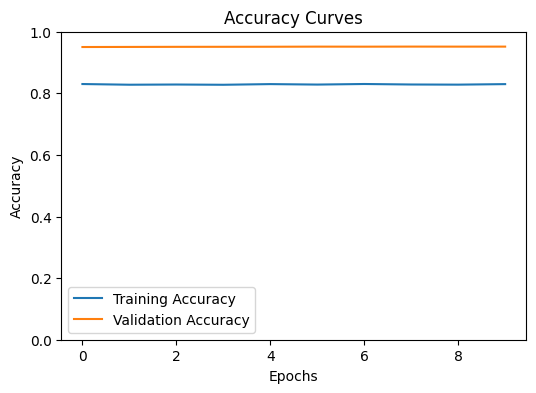

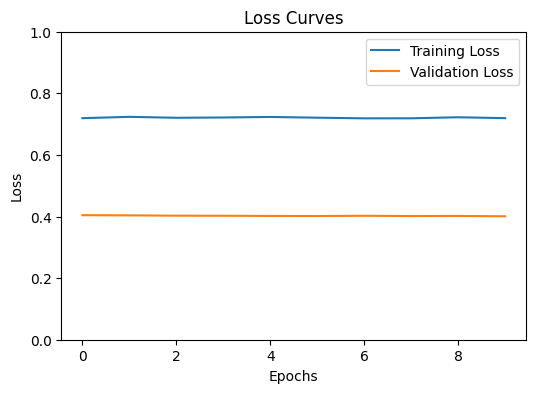

In [26]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
